In [225]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster        import KMeans
from sklearn.neural_network import MLPRegressor
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import torch
from torch.utils.data import Dataset, DataLoader

## Dataset Import and Feature Engineering

In [226]:
file_path = "vehiclesclean.csv"
if os.path.isfile(file_path):
    df = pd.read_csv(file_path)
else:
    df = kagglehub.load_dataset(
      KaggleDatasetAdapter.PANDAS,
      "austinreese/craigslist-carstrucks-data",
      file_path
    )
    df = df.drop(columns=['id', 'region', 'url', 'region_url', 'VIN', 'image_url', 'description', 'county', 'lat', 'long', 'posting_date'])

In [227]:
# print(len(df)) 426880 rows before dropping
df = df.dropna()
# print(len(df)) 79195 after dropping
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al
1,19900,2004.0,ford,f250 super duty,good,8 cylinders,diesel,88000.0,clean,automatic,4wd,full-size,pickup,blue,al
2,14000,2012.0,honda,odyssey,excellent,6 cylinders,gas,95000.0,clean,automatic,fwd,full-size,mini-van,silver,al
3,22500,2001.0,ford,f450,good,8 cylinders,diesel,144700.0,clean,manual,rwd,full-size,truck,white,al
4,15000,2017.0,dodge,charger rt 4dr sedan,excellent,8 cylinders,gas,90000.0,rebuilt,automatic,rwd,mid-size,sedan,grey,al


In [228]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = df.columns.values.tolist()

# Find categorical features
for col in features:
    if df[col].dtype in numerics: continue
    categorical_columns.append(col)

# Label encode categorical features
for col in categorical_columns:
    if col in df.columns:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

# Only use cars from last 15 years
df['year'] = (2025-df['year']).astype(int)
df = df[df['year'] < 15]

# Only using cars priced from 1-100k
df = df[df['price'] > 1000]
df = df[df['price'] < 150000]

# Binning odometer into groups of 5k
df['odometer'] = df['odometer'].astype(int)
df['odometer'] = df['odometer'] // 5000


def make_desc(row):
    return (
        f"This is a {row['condition']} {int(row['year'])} {row['manufacturer']} {row['model']}, "
        f"a {row['size']} sized {row['type']} with a {int(row['cylinders'])}-cylinder {row['fuel']} engine, "
        f"{row['transmission']} transmission, and {row['drive']} drive. "
        f"It has {int(row['odometer']):,} miles, holds a {row['title_status']} title in {row['state']}, "
        f"is painted {row['paint_color']}, predict its price."
    )

df['description'] = df.apply(make_desc, axis=1)

## Algorithms

In [229]:
def LR(X_train, X_test, y_train, y_test): # Linear Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)

    y_pred = lr.predict(X_test_scaled)

    return r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), y_pred

def PR(X_train, X_test, y_train, y_test): # Polynomial Regression
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    pr = LinearRegression()
    pr.fit(X_train_poly, y_train)

    y_pred = pr.predict(X_test_poly)

    return r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), y_pred

def DT(X_train, X_test, y_train, y_test): # Decision Tree
    dt = DecisionTreeRegressor(random_state=0)
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_test)

    return r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), y_pred

def NN(X_train, X_test, y_train, y_test): # Neural Network
    kmeans = KMeans(n_clusters=5, random_state=0)
    cluster_train = kmeans.fit_predict(X_train)
    cluster_test  = kmeans.predict(X_test)

    X_train_aug = np.hstack([X_train, cluster_train.reshape(-1,1)])
    X_test_aug  = np.hstack([X_test,  cluster_test.reshape( -1,1)])

    nn = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=0)
    nn.fit(X_train_aug, y_train)

    y_pred = nn.predict(X_test_aug)

    return r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), y_pred

In [230]:
X = df.drop(columns=['description', 'price'], axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)
lr_r2, lr_mse, lr_yp = LR(X_train, X_test, y_train, y_test)
pr_r2, pr_mse, pr_yp = PR(X_train, X_test, y_train, y_test)
dt_r2, dt_mse, dt_yp = DT(X_train, X_test, y_train, y_test)
nn_r2, nn_mse, nn_yp = NN(X_train, X_test, y_train, y_test)

### BERT Encoding

In [231]:
file_path = "dfbert.parquet"
if os.path.isfile(file_path):
    df = pd.read_parquet(file_path)
else:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    class TextDataset(Dataset):
        def __init__(self, texts):
            self.texts = texts
            
        def __len__(self):
            return len(self.texts)
            
        def __getitem__(self, idx):
            return self.texts[idx]

    def process_batch(batch):
        encoded = tokenizer(
            batch,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=128
        )
        
        encoded = {k: v.to(device) for k, v in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded)
        
        return outputs.last_hidden_state[:, 0, :].cpu().numpy()

    dataset = TextDataset(df['description'].tolist())
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    embeddings = []
    for batch in dataloader:
        embeddings.append(process_batch(batch))
        
    embeddings_matrix = np.vstack(embeddings)

    pca = PCA(n_components=50, random_state=0)
    reduced_embeddings = pca.fit_transform(embeddings_matrix)

    pca_cols  = [f'bert_pca_{i}'  for i in range(reduced_embeddings.shape[1])]
    pca_df  = pd.DataFrame(reduced_embeddings, columns=pca_cols,  index=df.index)

    df = pd.concat([df, pca_df], axis=1)
    df.to_parquet('dfbert.parquet')
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,...,bert_pca_40,bert_pca_41,bert_pca_42,bert_pca_43,bert_pca_44,bert_pca_45,bert_pca_46,bert_pca_47,bert_pca_48,bert_pca_49
0,15000,12,13,3869,0,5,2,25,0,0,...,-0.014806,-0.072666,0.029456,-0.001123,-0.010959,-0.033660,-0.014555,-0.022066,0.002443,-0.007173
2,14000,13,16,6337,0,5,2,19,0,0,...,-0.039510,0.058101,-0.142121,-0.040571,0.058490,0.024026,0.039786,-0.058320,0.024710,-0.083293
4,15000,8,10,2242,0,6,2,18,4,0,...,0.054159,-0.017318,-0.014214,0.063640,0.048207,0.104653,0.107923,0.007583,-0.007386,0.025610
12,22950,11,13,4150,0,6,2,33,0,0,...,0.028099,-0.066525,0.010853,-0.027153,-0.059374,-0.007863,0.039510,0.008674,-0.035969,0.045203
24,45000,8,7,7693,0,6,2,18,0,0,...,0.035923,-0.008015,0.060349,0.038550,-0.054897,0.086113,0.076920,0.015646,0.002071,-0.026181


In [232]:
X = df.drop(columns=['description', 'price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)
blr_r2, blr_mse, blr_yp = LR(X_train, X_test, y_train, y_test)
bpr_r2, bpr_mse, bpr_yp = PR(X_train, X_test, y_train, y_test)
bdt_r2, bdt_mse, bdt_yp = DT(X_train, X_test, y_train, y_test)
bnn_r2, bnn_mse, bnn_yp = NN(X_train, X_test, y_train, y_test)

## Results and Plotting

In [233]:
models = ["Linear Regression", "Polynomial Regression", "Decision Tree", "Neural Network"]

r2 = {
    "Standard": [lr_r2, pr_r2, dt_r2, nn_r2],
    "BERT":     [blr_r2, bpr_r2, bdt_r2, bnn_r2]
}

mse = {
    "Standard": [lr_mse, pr_mse, dt_mse, nn_mse],
    "BERT":     [blr_mse, bpr_mse, bdt_mse, bnn_mse]
}

y_pred = {
    "Standard": [lr_yp, pr_yp, dt_yp, nn_yp],
    "BERT":     [blr_yp, bpr_yp, bdt_yp, bnn_yp]
}

def print_table(title, data, fmt):
    print(title)
    header = " " * 12 + "".join(f"{m:<{30}}" for m in models)
    print(header)
    print("-" * (len(header) - 15))
    for row_name, vals in data.items():
        row = f"{row_name:<12}"
        for v in vals:
            spec = f"<{30}{fmt}"
            row += format(v, spec)
        print(row)
    print()

print_table("R-squared (R²)", r2, ".4f")
print_table("Mean Squared Error (MSE)", mse, ".2f")

R-squared (R²)
            Linear Regression             Polynomial Regression         Decision Tree                 Neural Network                
---------------------------------------------------------------------------------------------------------------------
Standard    0.6420                        0.7574                        0.7789                        0.7017                        
BERT        0.7175                        0.8196                        0.7172                        0.7516                        

Mean Squared Error (MSE)
            Linear Regression             Polynomial Regression         Decision Tree                 Neural Network                
---------------------------------------------------------------------------------------------------------------------
Standard    62069259.48                   42071854.79                   38338006.89                   51716725.03                   
BERT        48977651.94                   31278711.66     

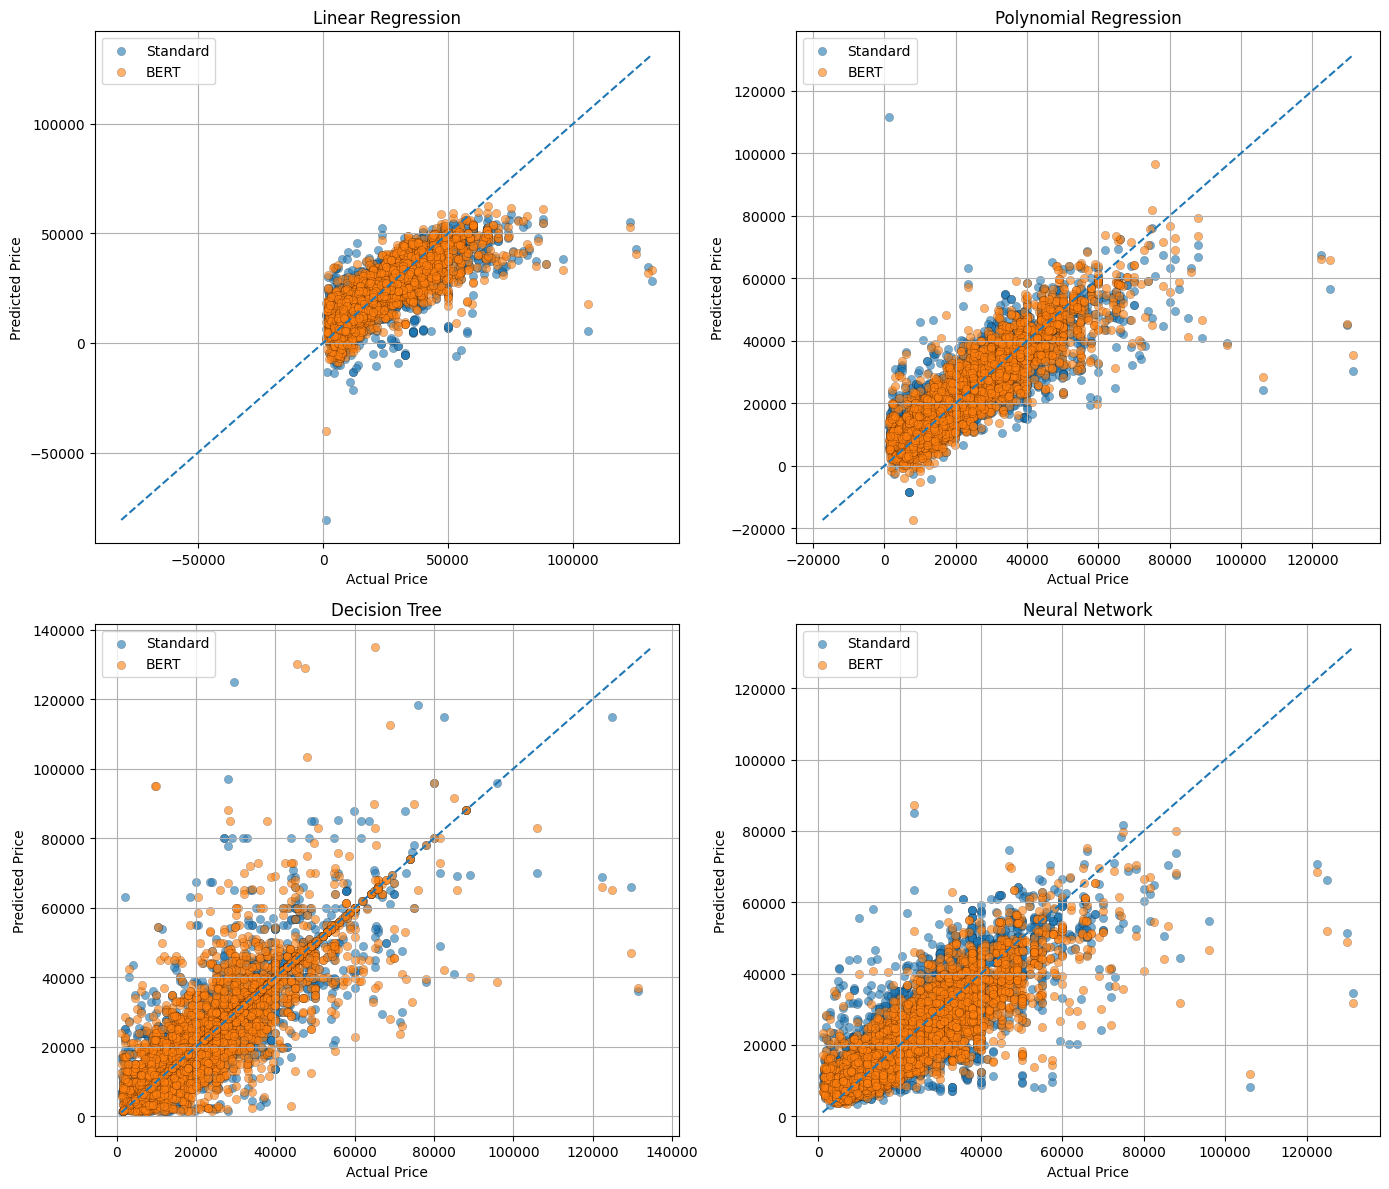

In [234]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    std_pred  = y_pred["Standard"][i]
    bert_pred = y_pred["BERT"][i]

    ax.scatter(y_test, std_pred,  alpha=0.6, label='Standard', edgecolor='k', linewidth=0.2)
    ax.scatter(y_test, bert_pred, alpha=0.6, label='BERT',     edgecolor='k', linewidth=0.2)

    mn = min(y_test.min(),  std_pred.min(),  bert_pred.min())
    mx = max(y_test.max(),  std_pred.max(),  bert_pred.max())
    ax.plot([mn, mx], [mn, mx], '--')

    ax.set_title(models[i])
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Predicted Price')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()
